# Дискретные случайные процессы и временные ряды, DS-поток
## Задание TS.5
### Поиск аномалий во временных рядах. Современные средства анализа временных рядов.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.


**Баллы за задание.**
  * Задача 1 &mdash; 80 баллов.
  * Задача 2 &mdash; 100 баллов.

In [1]:
# Bot check

# HW_ID: ds_ts5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
!pip install rrcf

In [3]:
!pip install "etna@git+https://github.com/etna-team/etna.git@master"

  Cloning https://github.com/etna-team/etna.git (to revision master) to /tmp/pip-install-q7hkl99b/etna_2f0d50b052464fd6b308de954607f326
  Running command git clone --filter=blob:none --quiet https://github.com/etna-team/etna.git /tmp/pip-install-q7hkl99b/etna_2f0d50b052464fd6b308de954607f326
  Resolved https://github.com/etna-team/etna.git to commit f05e03002d21f7d88b2c2d0a0b9aa1bb45eb4ba4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import rrcf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from etna.datasets import TSDataset
from etna.models import CatBoostPerSegmentModel
from etna.models import CatBoostMultiSegmentModel
from etna.transforms import LagTransform
from etna.transforms import DateFlagsTransform
from etna.transforms import FourierTransform
from etna.transforms import MeanTransform
from etna.transforms import YeoJohnsonTransform
from etna.transforms import SegmentEncoderTransform
from etna.pipeline import Pipeline
from etna.analysis import plot_backtest
from etna.analysis import metric_per_segment_distribution_plot

from etna.metrics import MSE
from etna.metrics import MAE
from etna.metrics import MAPE

from tqdm import tqdm

from IPython.display import clear_output

import warnings
warnings.simplefilter("ignore")

%matplotlib inline
sns.set(font_scale=1.3, palette="Set2")
sns.set()

/usr/local/lib/python3.11/dist-packages/etna/settings.py:35: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/usr/local/lib/python3.11/dist-packages/etna/settings.py:64: UserWarning: etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`
  warnings.warn("etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`")
/usr/local/lib/python3.11/dist-packages/etna/settings.py:89: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("etna[classification] is not available, to install it, run `pip install etna[classification]`")
/usr/local/lib/python3.11/dist-packages/etna/settings.py:98: UserWarning: etna[auto] is not available, to install it, run `pip install etna[auto]`
  warnings.warn("etna[auto] is not available, to install it, run `pip install et

---

### Задача 1

Вам [выдана](https://disk.yandex.ru/d/d9uxKFsst-YBkA) часть информации о визитах пользователей на сайте Физтех.Статистики начиная с 2020 года по данным Яндекс.Метрики. Визит — последовательность действий пользователя на сайте, которая
начинается на некоторой странице сайта, содержит в себе переходы по ссылкам (и другие действия), и
заканчивается на какой-то, возможно, другой страницей сайта. Визит считается завершенным, если
активность отсутствует в течение некоторого времени, обычно — 30 минут.
Описание полей доступно по [ссылке](https://yandex.ru/dev/metrika/doc/api2/logs/fields/visits.html).

Для начала загрузим данные. Нас будет интересовать общее количество посещений по дням. Постройте график временного ряда, что можно о нем сказать?

In [6]:
data = pd.read_csv("/miptstats_metrica.tsv", sep="\t")
data.columns = [col.replace('ym:s:', '') for col in data.columns]
data["dateTimeUTC"] = pd.to_datetime(data["dateTimeUTC"])

data.head()

,visitID,clientID,dateTimeUTC,startURL,endURL,pageViews,visitDuration,isNewUser,bounce,regionCountry,...,browserCountry,mobilePhone,operatingSystemRoot,browser,browserEngine,screenOrientation,screenWidth,screenHeight,windowClientWidth,windowClientHeight
0,1.801686e+19,1568056026568729022,2020-01-01 03:28:50,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,1,0,1,Russia,...,gb,NaN,gnu_linux,chrome,WebKit,2,1920,1080,1905,981
1,1.802359e+19,1577864187752491163,2020-01-01 10:36:27,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,9,215,1,0,Singapore,...,us,apple,ios_double,safari_mobile,WebKit,1,375,667,375,559
2,1.802460e+19,1567765219104836417,2020-01-01 11:40:44,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,88,0,0,Russia,...,ru,apple,ios_double,yandex_browser,WebKit,1,414,736,414,660
3,1.802475e+19,1576839432510419026,2020-01-01 11:50:13,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,19,0,0,China,...,ru,samsung,android,chromemobile,WebKit,1,412,892,412,756
4,1.802518e+19,1576246599115183097,2020-01-01 12:17:33,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,2,0,0,Russia,...,ru,NaN,gnu_linux,firefox,Gecko,2,1920,1080,913,942


In [7]:
visits_df = data[["dateTimeUTC", "visitID"]].set_index("dateTimeUTC").resample('D').count()
visits_df.head()

,visitID
dateTimeUTC,
2020-01-01,16
2020-01-02,28
2020-01-03,35
2020-01-04,36
2020-01-05,29


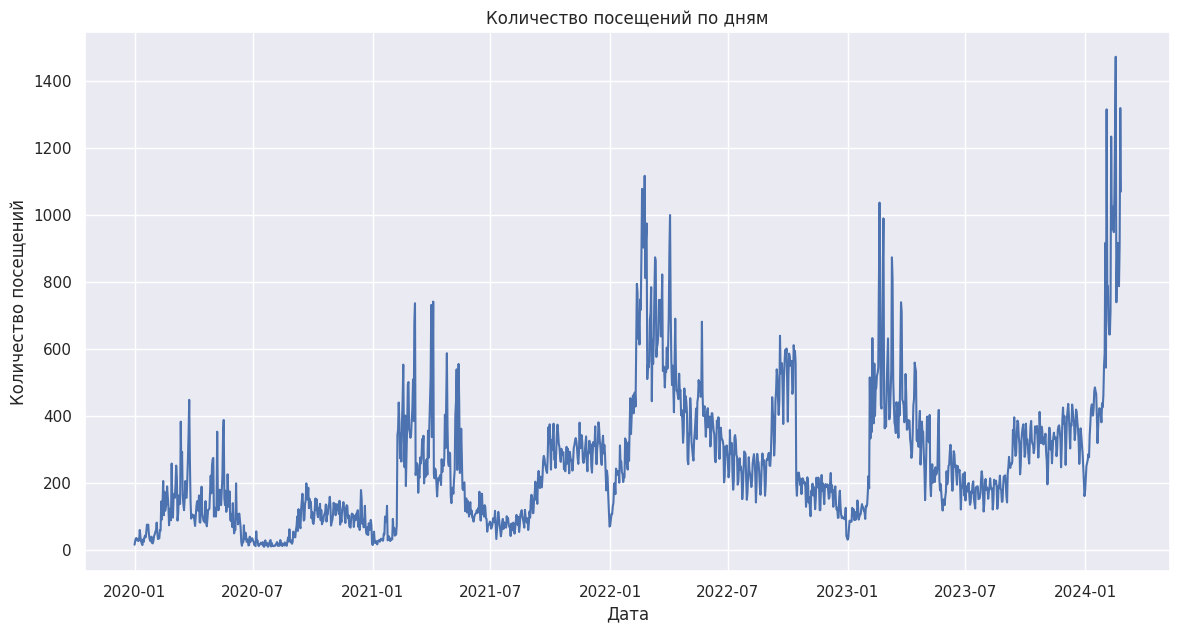

In [8]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=visits_df, x=visits_df.index, y='visitID')
plt.title('Количество посещений по дням')
plt.xlabel('Дата')
plt.ylabel('Количество посещений')
plt.grid(True)
plt.show()

Активность высока в периоды осеннего семестра, и особенно высока во время весеннего семестра. Летом и во время зимней сессии активность падает.

Заметим, что в графиках есть выраженные пики.

Задачи:
* Найти аномалии в предоставленных временных рядах постфактум, то есть построить оффлайн-модель. Попробуйте применить методы на основе фильтрации или метрические методы с использованием, например, DBSCAN.
* Построить онлайн-модель детектирования аномалий.

Попробуйте проинтерпретировать найденные аномалии. С чем они могут быть связаны?

*Замечание.*

Если будете использовать метод Seasonal ESD, то можете воспользоваться библиотекой [`sesd`](https://pypi.org/project/sesd/).

1) Попробуем применить DBSCAN

In [9]:
scaler = StandardScaler()
visits_df["visitID_scaled"] = scaler.fit_transform(visits_df[["visitID"]])

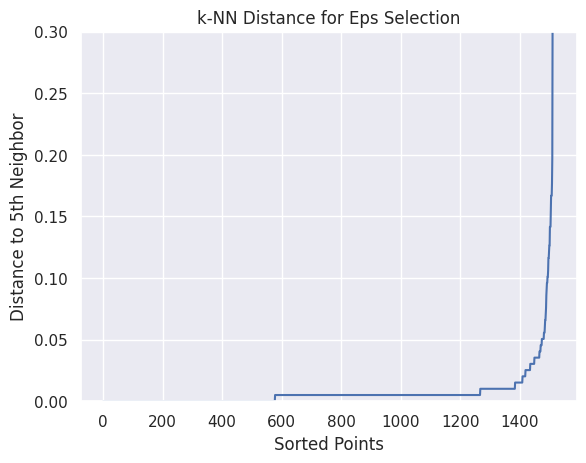

In [10]:
neighbors = NearestNeighbors(n_neighbors=5).fit(visits_df[["visitID_scaled"]])
distances, _ = neighbors.kneighbors(visits_df[["visitID_scaled"]])

plt.plot(np.sort(distances[:, -1]))
plt.title("k-NN Distance for Eps Selection")
plt.xlabel("Sorted Points")
plt.ylabel("Distance to 5th Neighbor")
plt.ylim(0, 0.3)
plt.show()

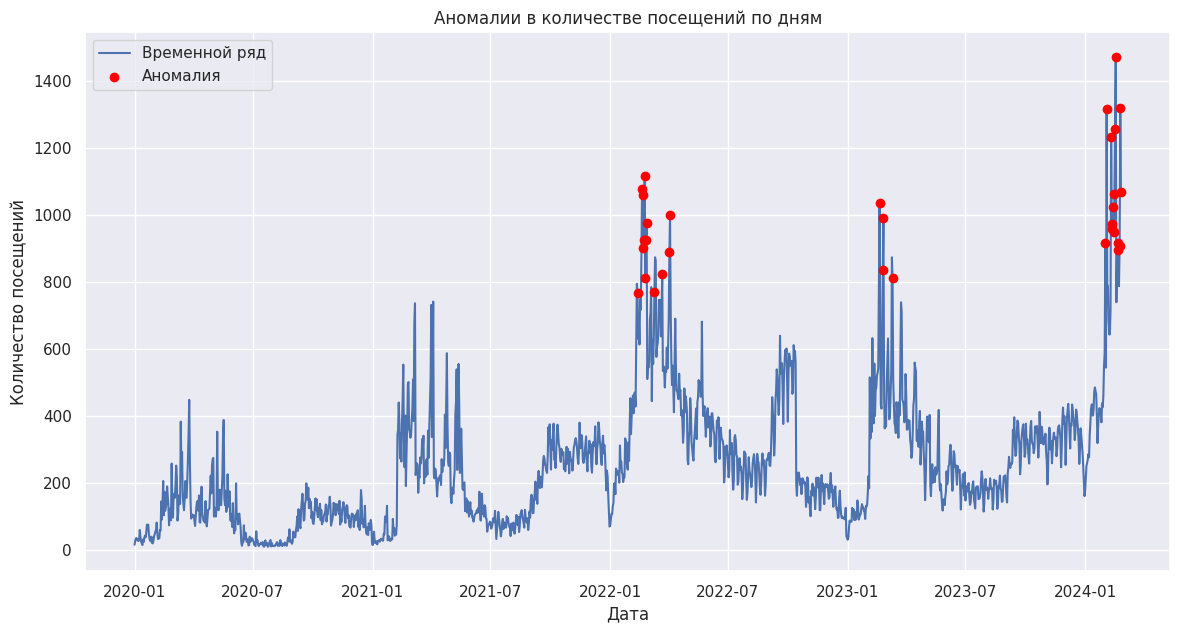

In [11]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
visits_df["cluster"] = dbscan.fit_predict(visits_df[["visitID_scaled"]])

# Визуализация аномалий
plt.figure(figsize=(14, 7))
plt.plot(visits_df.index, visits_df["visitID"], label="Временной ряд")
plt.scatter(
    visits_df.index[visits_df["cluster"] == -1],
    visits_df["visitID"][visits_df["cluster"] == -1],
    color="red",
    label="Аномалия",
    zorder=3,
)
plt.legend()
plt.title('Аномалии в количестве посещений по дням')
plt.xlabel('Дата')
plt.ylabel('Количество посещений')
plt.grid(True)
plt.show()

Посмотрим на конкретные даты аномалий.

In [12]:
anomalies = visits_df[visits_df["cluster"] == -1]
anomalies_dates = anomalies.index
print(anomalies_dates)

DatetimeIndex(['2022-02-12', '2022-02-19', '2022-02-20', '2022-02-21',
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-26', '2022-03-10', '2022-03-22', '2022-04-02',
               '2022-04-03', '2023-02-19', '2023-02-24', '2023-02-25',
               '2023-03-11', '2024-02-01', '2024-02-03', '2024-02-10',
               '2024-02-11', '2024-02-12', '2024-02-13', '2024-02-14',
               '2024-02-15', '2024-02-16', '2024-02-17', '2024-02-20',
               '2024-02-21', '2024-02-23', '2024-02-24', '2024-02-25'],
              dtype='datetime64[ns]', name='dateTimeUTC', freq=None)


Как видим почти все аномалии приходятся на февраля-март. Это может быть связано с резкой высокой нагрузко ДС-потока в начале семестра, а также с тем, что сайт начинают посещать много людей с курса ВвАД, который для некоторых является обязательным.

2) Теперь разберемся с онлайн методами.

In [13]:
num_trees = 128  # количество деревьев
shingle_size = 8  # размер окна (кол-во подряд идущих измерений)
tree_size = 256  # максимальное количество точек в дереве

# строим лес как список из пустых деревьев
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)


In [14]:
# Генератор для создания потока окон-точек
points = rrcf.shingle(visits_df["visitID_scaled"], size=shingle_size)

# Словарь степени аномальности каждой точки
avg_codisp = {}

# Для каждого окна
for index, point in tqdm(enumerate(points)):
    # для каждого дерева
    for tree in forest:
        # если дерево уже большое
        if len(tree.leaves) > tree_size:
            # удалим самую старую окно-точку
            tree.forget_point(index - tree_size)
        # добавим новую окно-точку
        tree.insert_point(point, index=index)
        # вычислим степень аномальности нового окна
        new_codisp = tree.codisp(index)
        # и усредним по всем деревьям
        if index not in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += new_codisp / num_trees

# Convert avg_codisp to a pandas Series
avg_codisp_series = pd.Series(avg_codisp)


1510it [02:03, 12.27it/s]


In [15]:
avg_codisp_series.index = visits_df.index[:len(avg_codisp_series)]

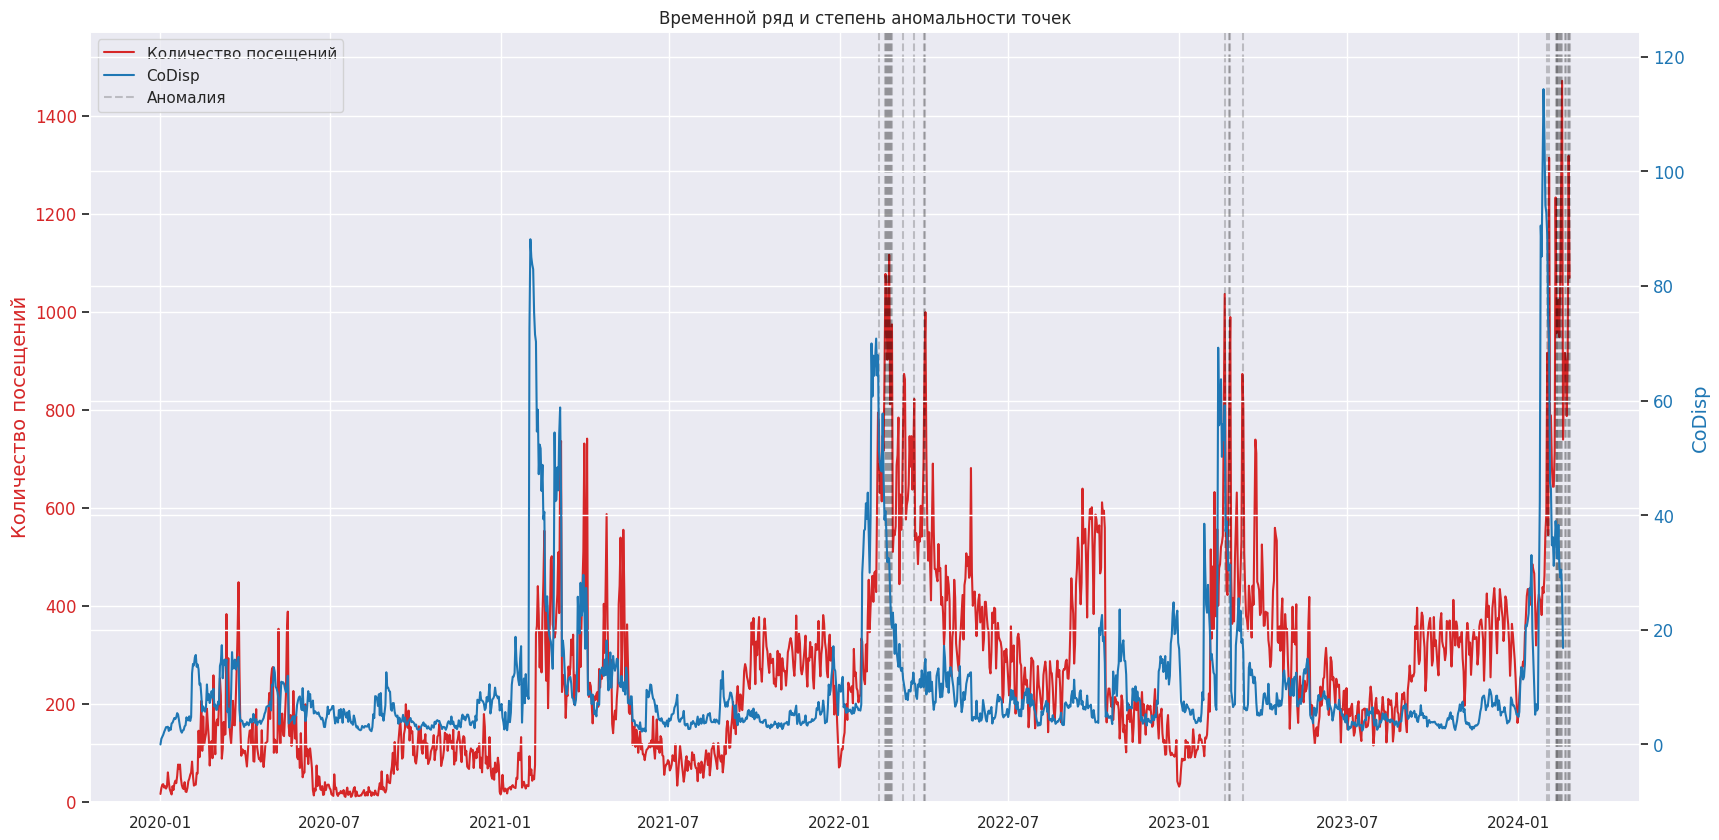

In [16]:
fig, ax1 = plt.subplots(figsize=(20, 10))  # Увеличиваем размер графика

# Ряд данных (красная линия)
color = "tab:red"
ax1.set_ylabel("Количество посещений", color=color, size=14)
line1, = ax1.plot(visits_df.index, visits_df["visitID"], color=color, label="Количество посещений")
ax1.tick_params(axis="y", labelcolor=color, labelsize=12)
ax1.set_ylim(0, visits_df["visitID"].max() + 100)

# Ряд степени аномальности точек (синяя линия)
ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("CoDisp", color=color, size=14)

# Обеспечиваем совпадение индексов
avg_codisp_aligned = avg_codisp_series.reindex(visits_df.index)

# Рисуем синюю линию
line2, = ax2.plot(visits_df.index, avg_codisp_aligned, color=color, label="CoDisp")
ax2.tick_params(axis="y", labelcolor=color, labelsize=12)
ax2.grid("off")
ax2.set_ylim(min(avg_codisp.values()) - 10, max(avg_codisp.values()) + 10)

# Рисуем вертикальные линии для аномалий
for border in anomalies.index:
    ax1.axvline(border, color="black", ls="--", alpha=0.2)

plt.title('Временной ряд и степень аномальности точек')

# Получаем объекты легенды с обеих осей
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Объединяем объекты легенды
handles = handles1 + handles2
labels = labels1 + labels2

# Добавляем легенду для аномалии
handles.append(plt.Line2D([0], [0], color="black", ls="--", alpha=0.2))
labels.append("Аномалия")

# Рисуем объединенную легенду на оси ax1
ax1.legend(handles, labels, loc="upper left")

plt.show()

In [17]:
anomalies_dates = anomalies.index
print(anomalies_dates)

DatetimeIndex(['2022-02-12', '2022-02-19', '2022-02-20', '2022-02-21',
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-26', '2022-03-10', '2022-03-22', '2022-04-02',
               '2022-04-03', '2023-02-19', '2023-02-24', '2023-02-25',
               '2023-03-11', '2024-02-01', '2024-02-03', '2024-02-10',
               '2024-02-11', '2024-02-12', '2024-02-13', '2024-02-14',
               '2024-02-15', '2024-02-16', '2024-02-17', '2024-02-20',
               '2024-02-21', '2024-02-23', '2024-02-24', '2024-02-25'],
              dtype='datetime64[ns]', name='dateTimeUTC', freq=None)


Видим ту же картину -- аномалии в основном в начале семестра: в февраля-марте. Это можно объснить добавлением людей с ВвАД и большой нагрузкой в начале семестра.

**Выводы**

Мы попробовали использовать два метода, и оба этих метода выявили аномалии примерно в одинаковый промежуток времени.

Заметим, что при использовании Robust cut tree мы также можем наблюдать степень аномальности временного ряда в разные промежутки времени.

---

### Задача 2

Как и прежде, будем работать с [данными](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) соревнования по прогнозированию спроса на товары. Рассмотрите 5 некоторых магазинов и 20 товаров, которые продаются в них. Таким образом, вам предлагается работать с 100 временными рядами. Как и до этого, разделите данные на обучение и тест, оставив для прогнозирования 365 последних измерений.

С использованием какого-нибудь фреймворка для работы с временными рядами, например, [ETNA](https://github.com/etna-team/etna), реализуйте и сравните следующие подходы к прогнозированию:

* Одна модель на все временные ряды
* Одна модель на товар, идентификатор магазина можно использовать как признак.
* Одна модель на магазин, идентификатор товара можно использовать как признак.
* Одна модель на каждый временной ряд, итого 100 моделей.

Используйте ML модель для табличных данных, например, какой-нибудь бустинг. Сравните результаты по метрике MAE, сделайте выводы.

In [18]:
data = pd.read_csv("/train.csv", parse_dates=["date"])
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Возьмем первые 5 магазинов и первые 20 товаров в них

In [19]:
data = data.sort_values('date')
data = data.loc[(data["store"] <= 5) & (data["item"] <= 20)]

data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
219120,2013-01-01,1,13,37
220946,2013-01-01,2,13,51
222772,2013-01-01,3,13,49
224598,2013-01-01,4,13,46


In [20]:
data["segment"] = (
    data["store"].astype(str).str.cat(data["item"].astype(str), sep="_")
)
data.rename({"date": "timestamp"}, axis=1, inplace=True)
data.rename({"sales": "target"}, axis=1, inplace=True)
data.head()

,timestamp,store,item,target,segment
0,2013-01-01,1,1,13,1_1
219120,2013-01-01,1,13,37,1_13
220946,2013-01-01,2,13,51,2_13
222772,2013-01-01,3,13,49,3_13
224598,2013-01-01,4,13,46,4_13


Теперь разделим наши данные на эндогенные и эзогенные.

In [21]:
data_endog = data[["timestamp", "segment", "target"]]
data_exog = data[["timestamp", "segment", "store", "item"]]

Создадим датасет

In [22]:
ts = TSDataset(df=data_endog, freq="D")
ts.head()

segment,1_1,1_10,1_11,1_12,1_13,1_14,1_15,1_16,1_17,1_18,...,5_19,5_2,5_20,5_3,5_4,5_5,5_6,5_7,5_8,5_9
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,37,37,33,37,22,42,14,13,38,...,20,26,20,14,4,9,20,21,30,21
2013-01-02,11,34,43,35,31,35,33,11,18,51,...,12,22,14,16,5,5,15,16,23,20
2013-01-03,14,32,34,41,50,26,45,12,15,42,...,17,26,29,15,8,3,37,25,37,15
2013-01-04,13,45,52,45,45,32,39,15,19,50,...,24,23,16,15,7,12,33,28,39,20
2013-01-05,10,35,45,46,49,31,47,22,16,56,...,17,22,14,10,7,8,20,32,37,23


In [23]:
ts.describe().head()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
1_1,2013-01-01,2017-12-31,1826,0,100,0,0,0,D
1_10,2013-01-01,2017-12-31,1826,0,100,0,0,0,D
1_11,2013-01-01,2017-12-31,1826,0,100,0,0,0,D
1_12,2013-01-01,2017-12-31,1826,0,100,0,0,0,D
1_13,2013-01-01,2017-12-31,1826,0,100,0,0,0,D


In [24]:
HORIZON = 365

1) Будем одной моделью предсказывать все временные ряды.

In [25]:
multi_segment_model = CatBoostMultiSegmentModel()

transforms = [
    YeoJohnsonTransform(in_column="target", inplace=True),
    LagTransform(
        in_column="target",
        lags=[HORIZON + i for i in range(100)],
        out_column="lag",
    ),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        is_weekend=True,
        out_column="date_flag",
    ),
    FourierTransform(period=365, order=20),
    MeanTransform(in_column=f"lag_{HORIZON}", window=10, seasonality=7),
]

multi_segment_transforms = transforms + [SegmentEncoderTransform()]
pipeline = Pipeline(
    model=multi_segment_model,
    transforms=multi_segment_transforms,
    horizon=HORIZON,
)

metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[MSE(), MAE(), MAPE()], n_folds=1, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s


Посмотрим на метрики

In [26]:
metrics_df.head()

,segment,MSE,MAE,MAPE,fold_number
0,1_1,22.087722,3.775649,19.516060,0
1,1_10,87.075098,7.487523,10.138571,0
2,1_11,74.810613,6.790501,9.911903,0
3,1_12,76.752043,7.045919,10.006640,0
4,1_13,91.679578,7.209841,8.674653,0


Посмотрим на распределение MAE

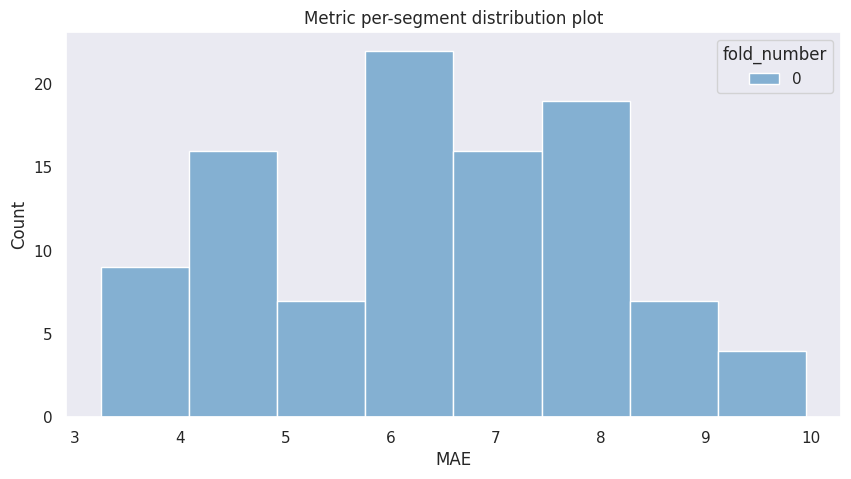

In [27]:
metric_per_segment_distribution_plot(metrics_df=metrics_df, metric_name="MAE")

Визуализируем предсказания для отдельных сегментов

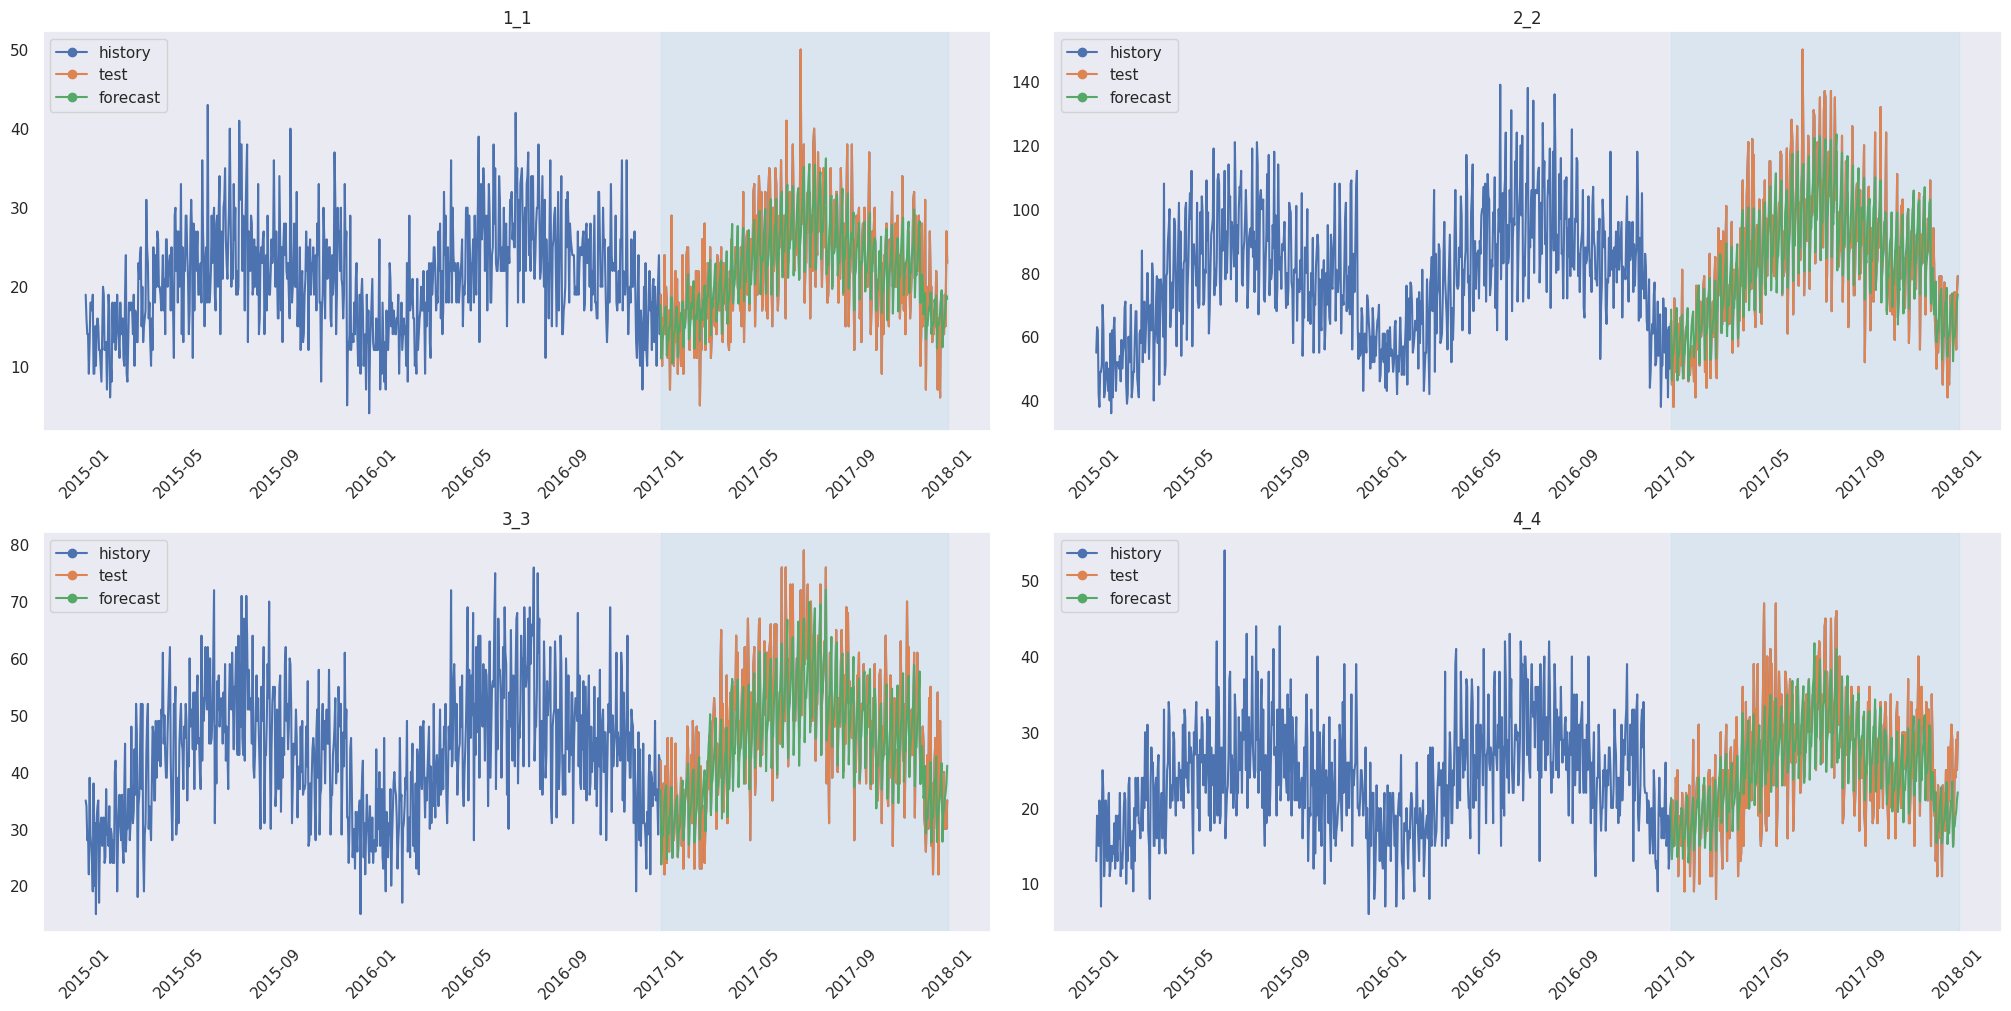

In [28]:
plot_backtest(
    forecast_df=forecast_df,
    ts=ts,
    history_len=2 * HORIZON,
    segments=["1_1", "2_2", "3_3", "4_4"],
)

Получилось достаточно неплохо.

Посмотрим на средние показатели

In [29]:
metrics_df[["MSE", "MAE", "MAPE"]].mean()

,0
MSE,68.813866
MAE,6.349704
MAPE,12.045662


2) Одна модель на товар, индентификатор магазина используем как признак.

In [30]:
item_metrics = []
item_models = []
item_forecasts = []

for item in tqdm(np.sort(data_exog["item"].unique())):
    data_endog_for_item = data_endog[data_exog["item"] == item]
    data_exog_for_item = data_exog[data_exog["item"] == item]

    ts_for_item = TSDataset(
        df=data_endog_for_item,
        freq="D",
        df_exog=data_exog_for_item
    )

    tmp_model = CatBoostMultiSegmentModel()
    pipeline = Pipeline(
        model=tmp_model,
        transforms=transforms,
        horizon=HORIZON,
    )

    metrics_df, forecast_df, fold_info_df = pipeline.backtest(
        ts=ts_for_item, metrics=[MSE(), MAE(), MAPE()], n_folds=1, n_jobs=-1
    )

    item_metrics.append(metrics_df)
    item_models.append(tmp_model)
    item_forecasts.append(forecast_df)

final_metrics = pd.concat(item_metrics)
final_models = item_models
final_forecasts = pd.concat(item_forecasts)

  0%|          | 0/20 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
  5%|▌         | 1/20 [00:49<15:36, 49.31s/it][Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
 10%|█         | 2/20 

In [31]:
final_metrics[['store', 'item']] = final_metrics['segment'].str.split('_', expand=True)
final_metrics['item'] = final_metrics['item'].astype(int)

mean_metrics_by_item = final_metrics.groupby('item')[['MSE', 'MAE', 'MAPE']].mean()
mean_metrics_by_item

,MSE,MAE,MAPE
item,,,
1,28.429378,4.217340,18.213704
2,81.717911,7.107818,11.148993
3,50.486059,5.526555,13.706962
4,28.313226,4.221365,18.286694
5,24.040400,3.846342,19.855198
6,78.285330,6.923522,10.758855
7,77.702440,7.021877,10.935919
8,103.795536,7.988105,9.540154
9,69.989735,6.613287,12.011717


А теперь посмотрим на среднее по всем моделям


In [32]:
mean_metrics_by_item["MAE"].mean()


6.545951071851673

Построим график для первой модели

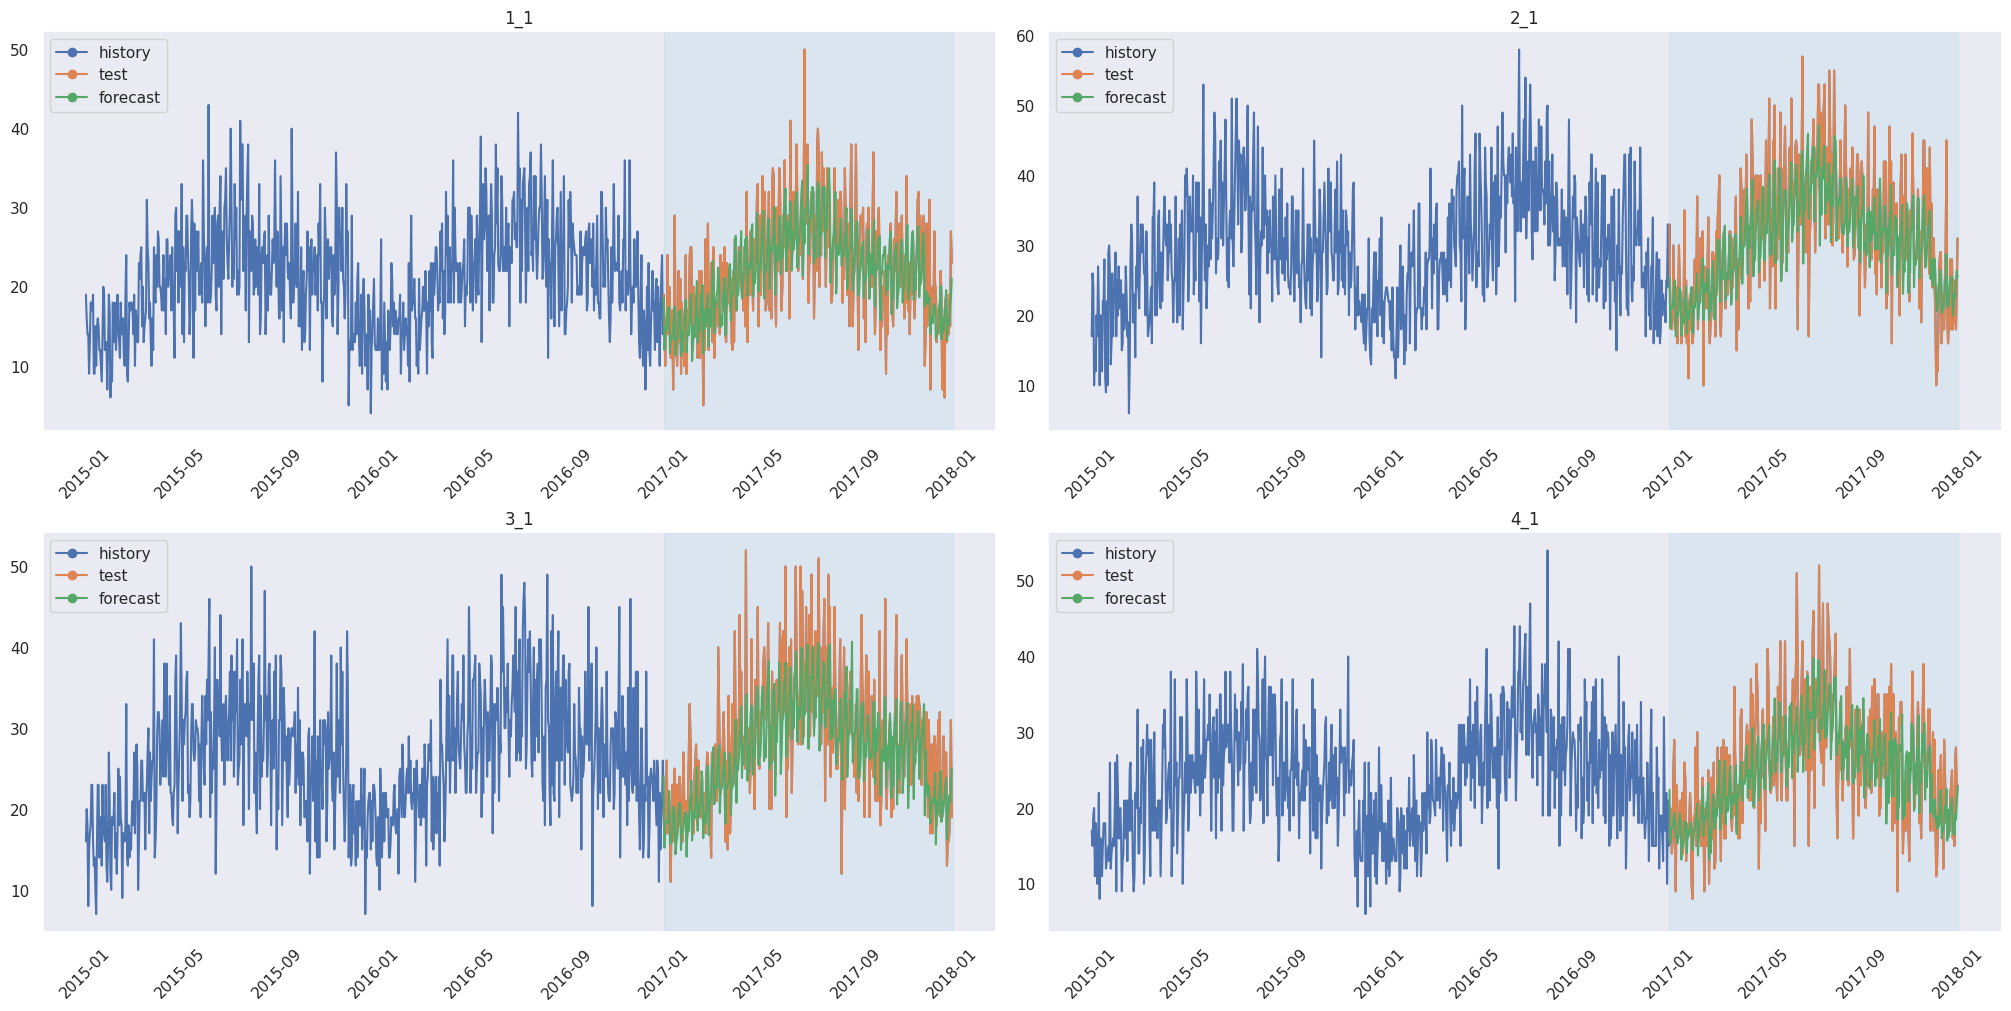

In [33]:
data_endog_for_item = data_endog[data_exog["item"] == 1]
data_exog_for_item = data_exog[data_exog["item"] == 1]

ts_for_item = TSDataset(
    df=data_endog_for_item,
    freq="D",
    df_exog=data_exog_for_item
)

plot_backtest(
    forecast_df=item_forecasts[0],
    ts=ts_for_item,
    history_len=2 * HORIZON,
    segments=["1_1", "2_1", "3_1", "4_1"],
)

3) Одна модель на магазин, идентификатор товара используем как признак

In [34]:
store_metrics = []
store_models = []
store_forecasts = []

for store_id in tqdm(np.sort(data_exog["store"].unique())):
    store_endog_data = data_endog[data_exog["store"] == store_id]
    store_exog_data = data_exog[data_exog["store"] == store_id]

    store_ts_data = TSDataset(
        df=store_endog_data,
        freq="D",
        df_exog=store_exog_data
    )

    model_for_store = CatBoostMultiSegmentModel()
    pipeline_for_store = Pipeline(
        model=model_for_store,
        transforms=transforms,
        horizon=HORIZON,
    )

    metrics_for_store, forecast_for_store, fold_info_for_store = pipeline_for_store.backtest(
        ts=store_ts_data, metrics=[MSE(), MAE(), MAPE()], n_folds=1, n_jobs=-1
    )

    store_metrics.append(metrics_for_store)
    store_models.append(model_for_store)
    store_forecasts.append(forecast_for_store)

all_store_metrics = pd.concat(store_metrics)
all_store_models = store_models
all_store_forecasts = pd.concat(store_forecasts)

  0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
 20%|██        | 1/5 [01:18<05:12, 78.18s/it][Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
 40%|████      | 2/5 [02

Посмотрим на средние

In [35]:
all_store_metrics[['store', 'item']] = all_store_metrics['segment'].str.split('_', expand=True)
all_store_metrics['store'] = all_store_metrics['store'].astype(int)
mean_metrics_by_store = all_store_metrics.groupby('store')[['MSE', 'MAE', 'MAPE']].mean()
mean_metrics_by_store


,MSE,MAE,MAPE
store,,,
1,61.632587,6.047772,13.036388
2,88.007989,7.195537,10.691747
3,79.851366,6.861513,11.461605
4,73.596770,6.586497,12.063952
5,51.524389,5.499587,13.954762


Теперь посмотрим на общее среднее

In [36]:
mean_metrics_by_store["MAE"].mean()

6.438181017155148

Отобразим предсказания первой модели

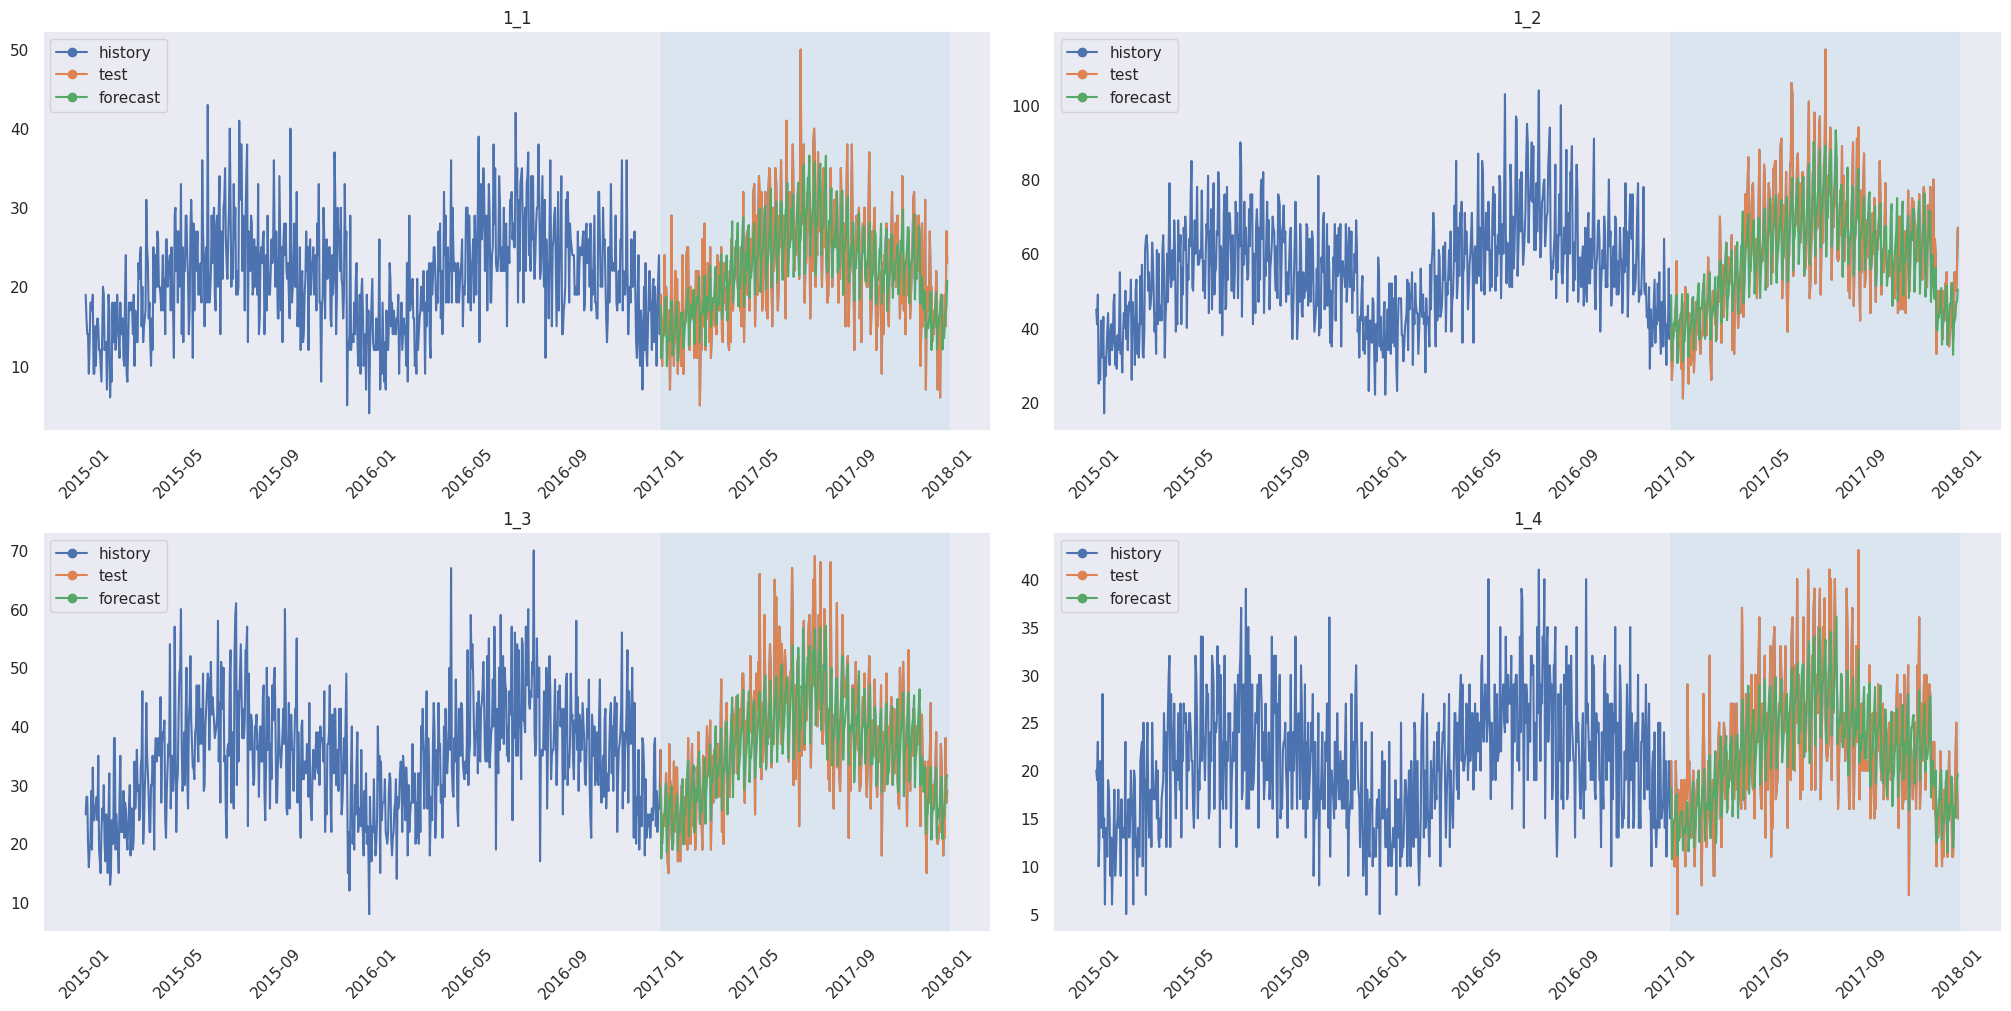

In [37]:
store_endog_data = data_endog[data_exog["store"] == 1]
store_exog_data = data_exog[data_exog["store"] == 1]

store_ts_data = TSDataset(
    df=store_endog_data,
    freq="D",
    df_exog=store_exog_data
)

plot_backtest(
    forecast_df=store_forecasts[0],
    ts=store_ts_data,
    history_len=2 * HORIZON,
    segments=["1_1", "1_2", "1_3", "1_4"],
)

4) Одна модель на каждый временной ряд

In [38]:
segment_metrics = []
segment_models = []
segment_forecasts = []

for segment in tqdm(np.sort(data_endog["segment"].unique())):
    segment_endog_data = data_endog[data_endog["segment"] == segment]

    ts_segment_data = TSDataset(
        df=segment_endog_data,
        freq="D"
    )

    model = CatBoostMultiSegmentModel()
    pipeline = Pipeline(
        model=model,
        transforms=transforms,
        horizon=HORIZON,
    )

    metrics, forecast, fold_info = pipeline.backtest(
        ts=ts_segment_data, metrics=[MSE(), MAE(), MAPE()], n_folds=1, n_jobs=-1
    )

    segment_metrics.append(metrics)
    segment_models.append(model)
    segment_forecasts.append(forecast)

all_segment_metrics = pd.concat(segment_metrics)
all_segment_models = segment_models
all_segment_forecasts = pd.concat(segment_forecasts)


  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
  1%|          | 1/100 [00:20<33:37, 20.38s/it][Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
  2%|▏         | 2/1

In [39]:
all_metrics = pd.concat(segment_metrics)
mean_metrics = all_metrics[['MSE', 'MAE', 'MAPE']].mean()

print("Средние метрики по всем сегментам:")
print(mean_metrics)

Средние метрики по всем сегментам:
MSE     80.984618
MAE      6.884244
MAPE    12.994796
dtype: float64


Теперь визуализируем некоторые модели

График для сегмента 4_14 построен.
График для сегмента 2_6 построен.
График для сегмента 4_4 построен.
График для сегмента 4_8 построен.


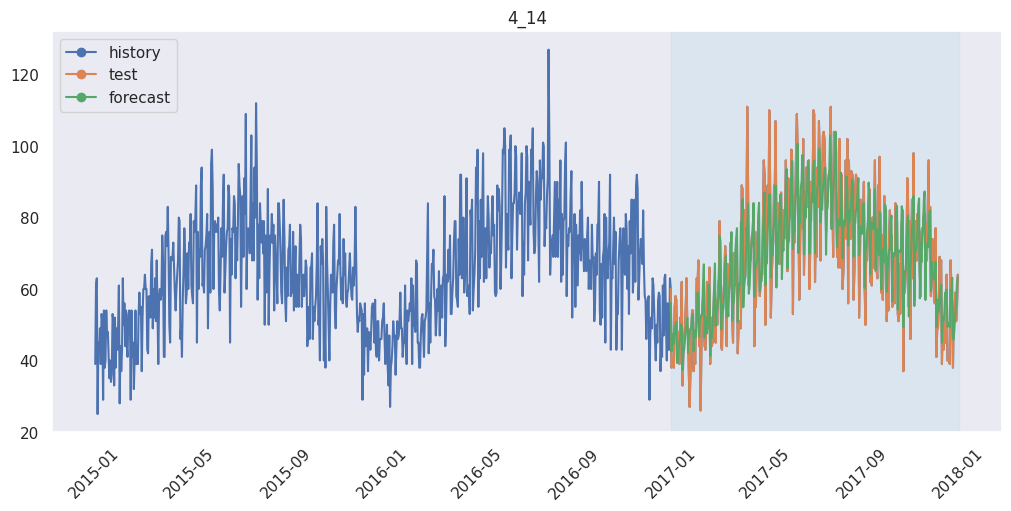

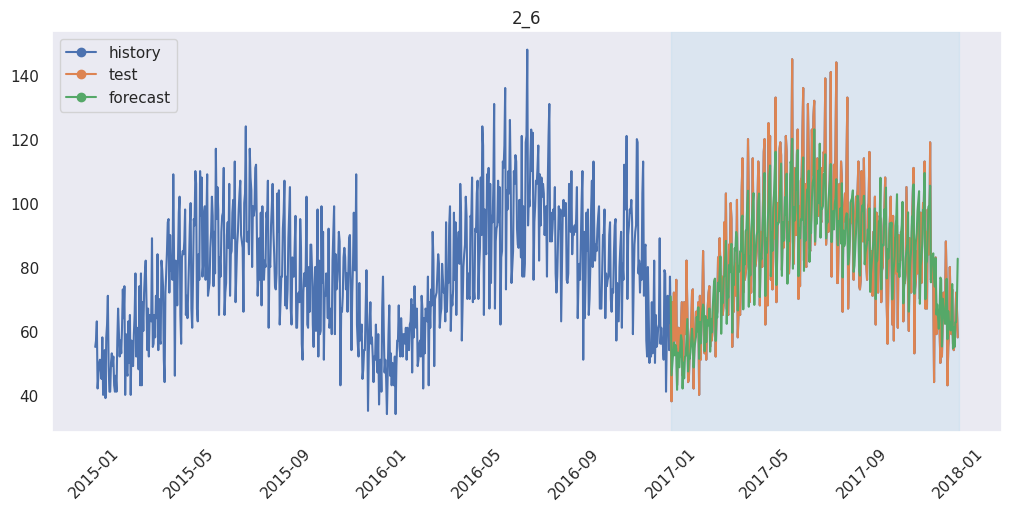

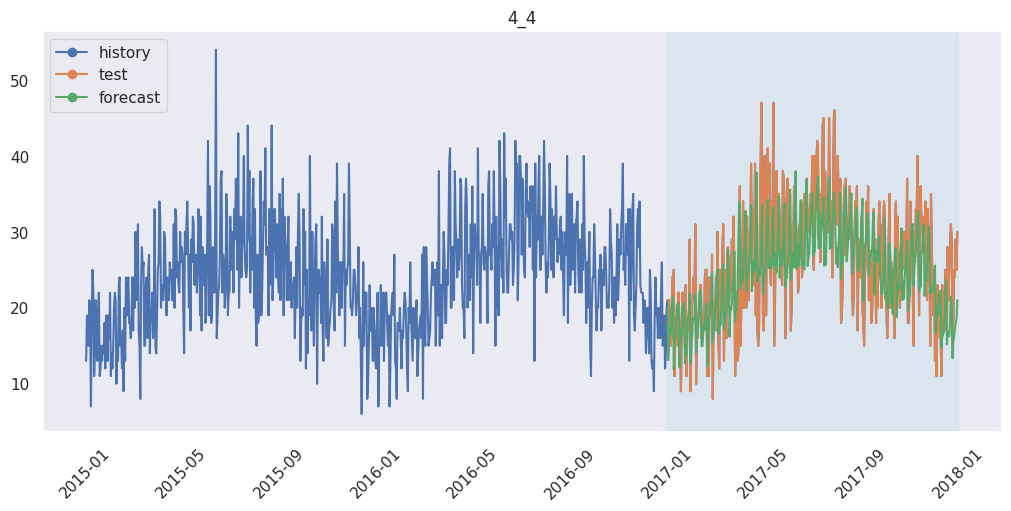

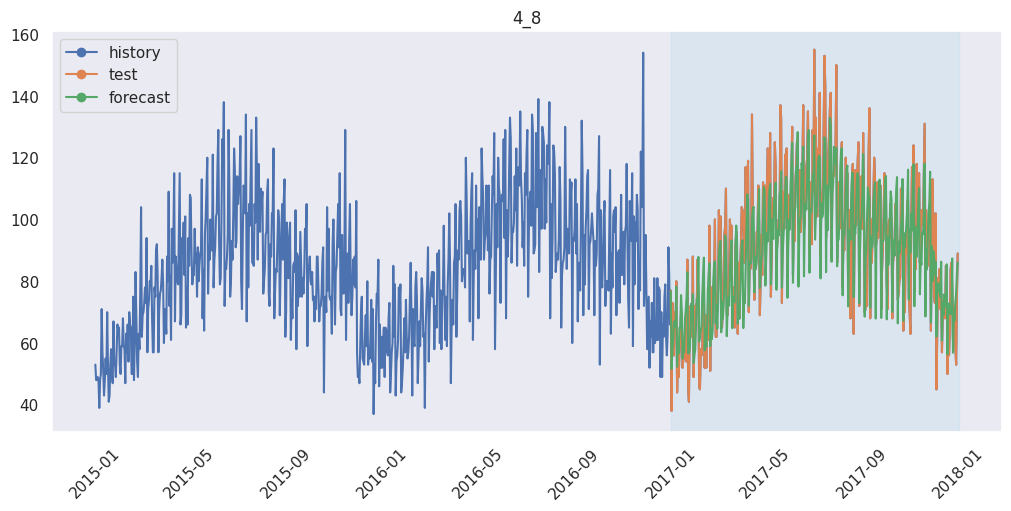

In [44]:
import random

def plot_random_segment(data_endog, data_exog, segment_forecasts, HORIZON):
    random_segment = random.choice(np.sort(data_endog["segment"].unique()))

    segment_endog_data = data_endog[data_endog["segment"] == random_segment]
    segment_exog_data = data_exog[data_exog["segment"] == random_segment]

    ts_data = TSDataset(
        df=segment_endog_data,
        freq="D",
        df_exog=segment_exog_data
    )

    forecast = segment_forecasts[np.where(np.sort(data_endog["segment"].unique()) == random_segment)[0][0]]

    plot_backtest(
        forecast_df=forecast,
        ts=ts_data,
        history_len=2 * HORIZON,
        segments=[random_segment],
    )

    print(f"График для сегмента {random_segment} построен.")

plot_random_segment(data_endog, data_exog, segment_forecasts, HORIZON)
plot_random_segment(data_endog, data_exog, segment_forecasts, HORIZON)
plot_random_segment(data_endog, data_exog, segment_forecasts, HORIZON)
plot_random_segment(data_endog, data_exog, segment_forecasts, HORIZON)

Видим, что предсказания получились неплохими.

In [46]:
# Среднее значение MAE для всех моделей (Одна модель на все временные ряды)
mean_mae_all = metrics_df[["MSE", "MAE", "MAPE"]].mean()["MAE"]
print(f"Среднее MAE для одной модели на все временные ряды: {mean_mae_all:.4f}")

# Среднее значение MAE для задачи "Одна модель на товар, идентификатор магазина"
mean_mae_item = mean_metrics_by_item["MAE"].mean()
print(f"Среднее MAE для одной модели на товар (с идентификатором магазина): {mean_mae_item:.4f}")

# Среднее значение MAE для задачи "Одна модель на магазин, идентификатор товара"
mean_mae_store = mean_metrics_by_store["MAE"].mean()
print(f"Среднее MAE для одной модели на магазин (с идентификатором товара): {mean_mae_store:.4f}")

# Среднее значение MAE для задачи "Одна модель на каждый временной ряд, итого 100 моделей"
mean_mae_segment = all_metrics[['MSE', 'MAE', 'MAPE']].mean()['MAE']
print(f"Среднее MAE для каждой модели (по 100 моделям на каждый временной ряд): {mean_mae_segment:.4f}")

Среднее MAE для одной модели на все временные ряды: 6.2406
Среднее MAE для одной модели на товар (с идентификатором магазина): 6.5460
Среднее MAE для одной модели на магазин (с идентификатором товара): 6.4382
Среднее MAE для каждой модели (по 100 моделям на каждый временной ряд): 6.8842


**Выводы**

Удивительно, но одна модель на все товары демонстрирует наименьший MAE, возможно это связано с добавлением к трансформациями SegmentEncoderTransform.

MAE для модели на товара или модели на магазин отличаются менее, чем на 10%, что может говорить о непринципиальности такого разбиения.

Подводя итог, можно говорить о том, что все модели показали приемлемо хороший результат, что говорит о жизнеспособности выбранного подхода.